# Medium model (https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7)

# Environment Sound Classification Using a Two-Stream CNN Based on Decision-Level Fusion
 (https://docs.google.com/presentation/d/1M5D-h6AwXPxs7P_QaO7xW3yuaW6l7tQglIglTKNyAE4/edit?usp=sharing)

In [2]:
import matplotlib as mpl
#mpl.use('Agg')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import tensorflow as tf

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [6]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
from keras import optimizers, Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPool2D,SeparableConv2D
from keras.utils import np_utils, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications import DenseNet121

Using TensorFlow backend.


In [9]:
from sklearn import metrics, svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder

In [ ]:
#./Heart/CV_0001_0100/CV_0002/CV_0002_6.wav
audio, sample_rate = librosa.load("./Heart/CV_0001_0100/CV_0001/CV_0001_1_1.wav", res_type='kaiser_fast')
#audio, sample_rate = librosa.load("./Heart/CV_0001_0100/CV_0001/CV_0001_1_1.wav", res_type='kaiser_fast')
#mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
#print(mfccs.shape)
mels = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=2000)
#mels = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=1024, hop_length=512, n_mels=128, fmax=200 )
print(mels.shape)
chromagram = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
print(chromagram.shape)
#S = np.abs(librosa.stft(audio))
#contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
#print(contrast.shape)
##T = librosa.effects.harmonic(audio)
#tonnetz = librosa.feature.tonnetz(y=T, sr=sample_rate)
#print(tonnetz.shape)

## Function

In [ ]:
def extract_features(file_name):
    print(file_name)
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mels = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=1024, hop_length=512, n_mels=128, fmax=2000 )
        print(mels.shape)
        chromagram = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        #print(chromagram.shape)
        S = np.abs(librosa.stft(audio))
        contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate)
        #print(contrast.shape)
        T = librosa.effects.harmonic(audio)
        tonnetz = librosa.feature.tonnetz(y=T, sr=sample_rate)
        #print(tonnetz.shape)
        
        all_1=np.append(mels,chromagram, axis=0)
        all_2=np.append(all_1,contrast, axis=0)
        all_3=np.append(all_2,tonnetz, axis=0)
        
    except Exception as e:
#         print("Error encountered while parsing file: ", file_name)
        return None 
    
    if all_3.shape == (0, 0):
        return none
    else:
        print(all_3.shape)
        return all_3

## Read Data

In [ ]:
metadata = pd.read_csv("Heart/metadata.csv")

In [ ]:
features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():    
    file_name = row["filename"]
    class_label = row["class"]
    data = extract_features(file_name)
    n = file_name.split("/")[-2]
    features.append([data, class_label, n])
featuresdf = pd.DataFrame(features, columns=['feature','class_label', 'N']).dropna()

In [ ]:
featuresdf.shape

## Data Processing

In [ ]:
N = np.array(list(set(featuresdf.N)))
mask = np.ones(N.shape,dtype=bool) #np.ones_like(a,dtype=bool)
mask[np.random.choice(len(N), int(len(N) * 0.9), replace=False)] = False

train = N[~mask]
test = N[mask]

featuresdf.index = list(featuresdf.N)

In [ ]:
test

In [ ]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.loc[train].feature.tolist())
y = np.array(featuresdf.loc[train].class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

x_train = X
y_train = yy
# x_train, _, y_train, _ = train_test_split(X, yy, test_size=0.1, random_state = 42)

In [ ]:
y_train

In [ ]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.loc[test].feature.tolist())
y = np.array(featuresdf.loc[test].class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
x_test = X
y_test = yy
# x_test, _, y_test, _ = train_test_split(X, yy, test_size=0.0, random_state = 42)

## Init

In [ ]:
num_rows = 153
num_columns = 431
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]

In [ ]:
num_labels

In [ ]:
np.save('x_train_lm.npy', x_train)
np.save('y_train_lm.npy', y_train)
np.save('x_test_lm.npy', x_test)
np.save('y_test_lm.npy', y_test)
np.save('num_labels_lm.npy', num_labels)

In [13]:
x_train=np.load("x_train_lm.npy")
y_train=np.load("y_train_lm.npy")
x_test=np.load("x_test_lm.npy")
y_test=np.load("y_test_lm.npy")
num_labels=np.load("num_labels_lm.npy")
num_rows = 153
num_columns = 431
num_channels = 1

In [34]:
x_test.shape

(231, 153, 431, 1)

In [14]:
#model = Sequential()
#model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

#model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())

#model.add(Dense(num_labels, activation='softmax'))
#model.summary()

Jay modify

In [63]:
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(SeparableConv2D(filters=32, kernel_size=(3,3),strides=(2,2), input_shape=(num_rows, num_columns, num_channels)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

model.add(SeparableConv2D(filters=64, kernel_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

model.add(SeparableConv2D(filters=64, kernel_size=(3,3),strides=(2,2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))

model.add(SeparableConv2D(filters=128, kernel_size=(3,3),strides=(2,2)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

#model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_37 (Separab (None, 76, 215, 32)       73        
_________________________________________________________________
batch_normalization_11 (Batc (None, 76, 215, 32)       128       
_________________________________________________________________
activation_37 (Activation)   (None, 76, 215, 32)       0         
_________________________________________________________________
separable_conv2d_38 (Separab (None, 37, 107, 64)       2400      
_________________________________________________________________
batch_normalization_12 (Batc (None, 37, 107, 64)       256       
_________________________________________________________________
activation_38 (Activation)   (None, 37, 107, 64)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 53, 64)        0         
__________

## Training

In [64]:
optimizer = optimizers.Adam(lr=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
h=model.fit(x_train, y_train, batch_size=32, epochs=1000, validation_data=(x_test, y_test))

Train on 2033 samples, validate on 231 samples
Epoch 1/1000
2033/2033 [==============================] - 6s 3ms/step - loss: 1.7886 - acc: 0.1913 - val_loss: 1.7869 - val_acc: 0.1861
Epoch 2/1000
2033/2033 [==============================] - 5s 2ms/step - loss: 1.7795 - acc: 0.1820 - val_loss: 1.7794 - val_acc: 0.1861
Epoch 3/1000
2033/2033 [==============================] - 5s 2ms/step - loss: 1.7664 - acc: 0.1815 - val_loss: 1.7694 - val_acc: 0.1775
Epoch 4/1000
2033/2033 [==============================] - 4s 2ms/step - loss: 1.7589 - acc: 0.1899 - val_loss: 1.7636 - val_acc: 0.2381
Epoch 5/1000
2033/2033 [==============================] - 4s 2ms/step - loss: 1.7550 - acc: 0.2046 - val_loss: 1.7581 - val_acc: 0.1905
Epoch 6/1000
2033/2033 [==============================] - 5s 2ms/step - loss: 1.7491 - acc: 0.1982 - val_loss: 1.7533 - val_acc: 0.1775
Epoch 7/1000
2033/2033 [==============================] - 5s 2ms/step - loss: 1.7442 - acc: 0.2071 - val_loss: 1.7485 - val_acc: 0.1688
E

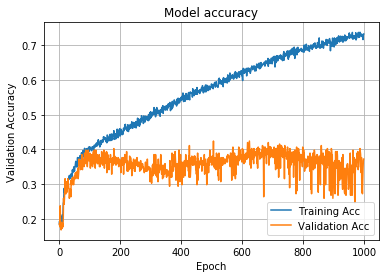

In [65]:
# 比较两种模型的精确度
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Validation Acc'], loc='lower right')
plt.grid(True)
plt.show()

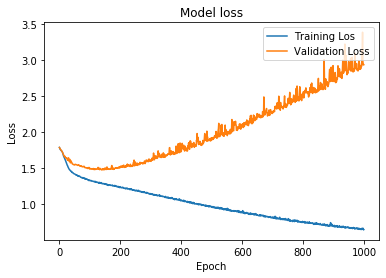

In [66]:
# 比较两种模型的损失率
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Los', 'Validation Loss'], loc='upper right')
plt.show()

## Confusion Matrix

In [ ]:
preds = model.predict(x_test).argmax(axis=1)

In [ ]:
y = y_test.argmax(axis=1)

In [ ]:
confusion_matrix(y, preds)

In [ ]:
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
#y_predict = preds
#y_pred = convert_to_labels(y_predict)
#y_true = convert_to_labels(y)
target_names = [ '0','1' ,'2','3','4','5']
#print ("month = " + str(month))
#print(classification_report(y_true, y_pred, target_names=target_names))
#print ("**************************************************************")

plt.figure()
cnf_matrix = confusion_matrix(y, preds)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()

In [39]:
x_train.min()

-0.499097532800441

In [41]:
x_test.min()

-0.47592908720975463

In [45]:
x_train.max()


5092.041540970657

In [44]:
x_test.max()

5293.054538898414